# Text Mining & Search
Authors
- Alexandre Crivellari
- Andrea Muscio

# Introduction

[TO DO]

# Workspace setting

## Dependencies

In [2]:
# Uncomment if needed to install the required packages

#%pip install pandas numpy matplotlib seaborn scikit-learn
#%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
#%pip install captum

## Libraries

In [25]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from transformers import RobertaTokenizer
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

## Dataset upload and exploration

In [4]:
# Define the column names
columns = ['id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state_info', 
           'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 
           'mostly_true_counts', 'pants_on_fire_counts', 'context']

# Read the TSV files
train_df = pd.read_csv('train.tsv', sep='\t', names=columns)
valid_df = pd.read_csv('valid.tsv', sep='\t', names=columns)
test_df = pd.read_csv('test.tsv', sep='\t', names=columns)

# Display the first few rows of the training data
train_df.head()

,id,label,statement,subject,speaker,job_title,state_info,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [5]:
print(train_df.columns)

Index(['id', 'label', 'statement', 'subject', 'speaker', 'job_title',
       'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts',
       'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts',
       'context'],
      dtype='object')


In [6]:
# Check for missing values
print(train_df.isnull().sum())

id                         0
label                      0
statement                  0
subject                    2
speaker                    2
job_title               2898
state_info              2210
party_affiliation          2
barely_true_counts         2
false_counts               2
half_true_counts           2
mostly_true_counts         2
pants_on_fire_counts       2
context                  102
dtype: int64


In [8]:
# TEST REMOVING COLUMNS
# Remove 'job_title' and 'state_info' columns from all datasets
columns_to_remove = ['job_title', 'state_info']

train_df = train_df.drop(columns=columns_to_remove)
valid_df = valid_df.drop(columns=columns_to_remove)
test_df = test_df.drop(columns=columns_to_remove)

# Verify the columns have been removed
print(train_df.columns)

Index(['id', 'label', 'statement', 'subject', 'speaker', 'party_affiliation',
       'barely_true_counts', 'false_counts', 'half_true_counts',
       'mostly_true_counts', 'pants_on_fire_counts', 'context'],
      dtype='object')


id                      0
label                   0
statement               0
subject                 0
speaker                 0
party_affiliation       0
barely_true_counts      0
false_counts            0
half_true_counts        0
mostly_true_counts      0
pants_on_fire_counts    0
context                 0
dtype: int64
label
half-true      0.206445
false          0.194824
mostly-true    0.191602
true           0.163672
barely-true    0.161523
pants-fire     0.081934
Name: proportion, dtype: float64


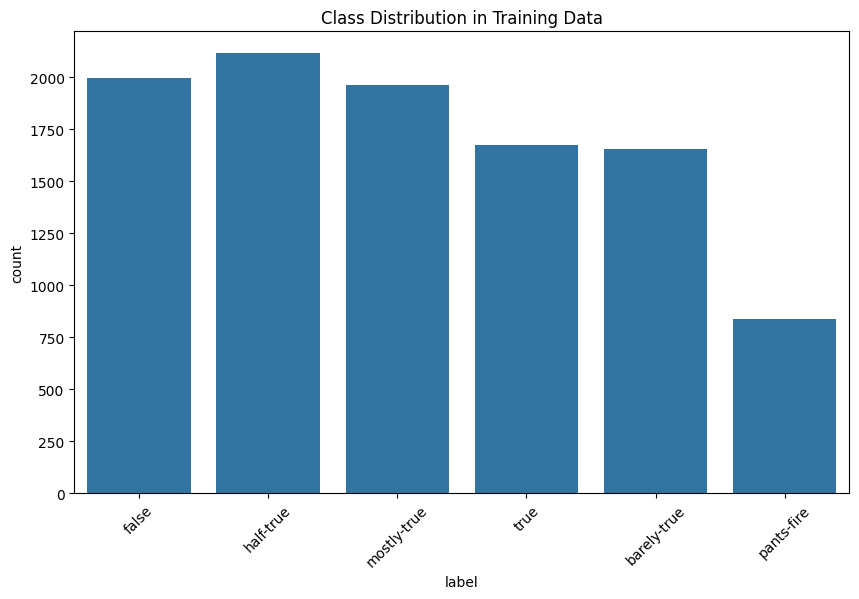

In [10]:
# Check for missing values
print(train_df.isnull().sum())

# Handle missing values (if any)
train_df = train_df.fillna('unknown')
valid_df = valid_df.fillna('unknown')
test_df = test_df.fillna('unknown')

# Handle missing values
categorical_columns = ['subject', 'speaker', 'party_affiliation', 'context']
numeric_columns = ['barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts']

# For categorical columns, fill with 'Unknown' instead of 'unknown'
for col in categorical_columns:
    train_df[col] = train_df[col].fillna('Unknown')
    valid_df[col] = valid_df[col].fillna('Unknown')
    test_df[col] = test_df[col].fillna('Unknown')

# For numeric columns, ensure they are numeric and fill with median
for col in numeric_columns:
    train_df[col] = pd.to_numeric(train_df[col], errors='coerce')
    valid_df[col] = pd.to_numeric(valid_df[col], errors='coerce')
    test_df[col] = pd.to_numeric(test_df[col], errors='coerce')
    
    median_value = train_df[col].median()
    train_df[col] = train_df[col].fillna(median_value)
    valid_df[col] = valid_df[col].fillna(median_value)
    test_df[col] = test_df[col].fillna(median_value)

# Encode labels
le = LabelEncoder()
train_df['label_encoded'] = le.fit_transform(train_df['label'])
valid_df['label_encoded'] = le.transform(valid_df['label'])
test_df['label_encoded'] = le.transform(test_df['label'])

# Display class distribution
print(train_df['label'].value_counts(normalize=True))

# Visualize class distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=train_df)
plt.title('Class Distribution in Training Data')
plt.xticks(rotation=45)
plt.show()

## Feature Engineering

In [11]:
# Step 2: Feature Engineering (updated)

# Create a feature for statement length
train_df['statement_length'] = train_df['statement'].str.len()
valid_df['statement_length'] = valid_df['statement'].str.len()
test_df['statement_length'] = test_df['statement'].str.len()

# Aggregate count features
count_columns = ['barely_true_counts', 'false_counts', 'half_true_counts', 
                 'mostly_true_counts', 'pants_on_fire_counts']

train_df['total_statements'] = train_df[count_columns].sum(axis=1)
valid_df['total_statements'] = valid_df[count_columns].sum(axis=1)
test_df['total_statements'] = test_df[count_columns].sum(axis=1)

# Task 1 - Text Classification (Binary)

Preprocessing

Class distribution in training set:
binary_label
False    0.644727
True     0.355273
Name: proportion, dtype: float64

Class distribution in validation set:
binary_label
False    0.672897
True     0.327103
Name: proportion, dtype: float64

Class distribution in test set:
binary_label
False    0.64562
True     0.35438
Name: proportion, dtype: float64


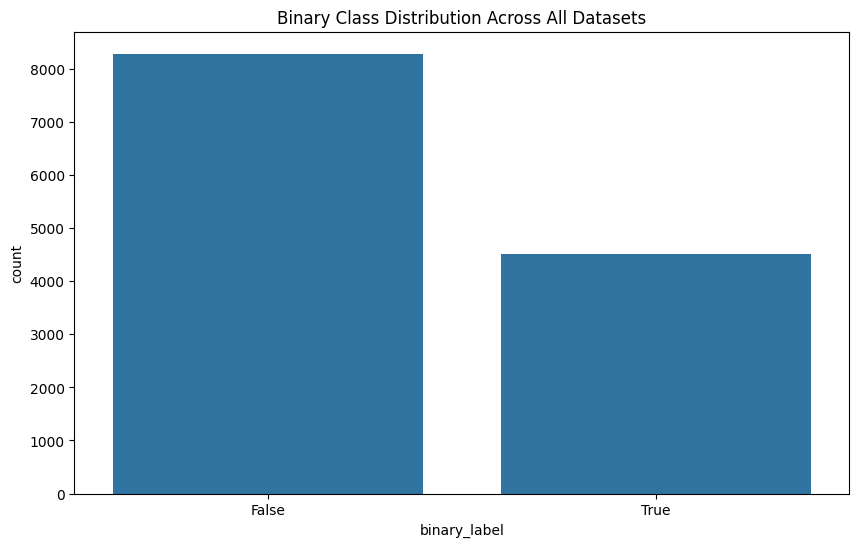

In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Assuming you have already loaded your datasets into train_df, valid_df, and test_df

def binarize_labels(label):
    if label in ['true', 'mostly-true']:
        return 'True'
    else:
        return 'False'

# Apply binary labeling to all datasets
train_df['binary_label'] = train_df['label'].apply(binarize_labels)
valid_df['binary_label'] = valid_df['label'].apply(binarize_labels)
test_df['binary_label'] = test_df['label'].apply(binarize_labels)

# Encode binary labels
le = LabelEncoder()
train_df['label_encoded'] = le.fit_transform(train_df['binary_label'])
valid_df['label_encoded'] = le.transform(valid_df['binary_label'])
test_df['label_encoded'] = le.transform(test_df['binary_label'])

# Display class distribution
print("Class distribution in training set:")
print(train_df['binary_label'].value_counts(normalize=True))

print("\nClass distribution in validation set:")
print(valid_df['binary_label'].value_counts(normalize=True))

print("\nClass distribution in test set:")
print(test_df['binary_label'].value_counts(normalize=True))

# Visualize class distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(x='binary_label', data=pd.concat([train_df, valid_df, test_df]))
plt.title('Binary Class Distribution Across All Datasets')
plt.show()

In [16]:
# Print some sample rows to verify the transformation
print("\nSample rows from the training set:")
print(train_df[['statement', 'label', 'binary_label', 'label_encoded']].head(10))


Sample rows from the training set:
                                           statement        label  \
0  Says the Annies List political group supports ...        false   
1  When did the decline of coal start? It started...    half-true   
2  Hillary Clinton agrees with John McCain "by vo...  mostly-true   
3  Health care reform legislation is likely to ma...        false   
4  The economic turnaround started at the end of ...    half-true   
5  The Chicago Bears have had more starting quart...         true   
6  Jim Dunnam has not lived in the district he re...  barely-true   
7  I'm the only person on this stage who has work...    half-true   
8  However, it took $19.5 million in Oregon Lotte...    half-true   
9  Says GOP primary opponents Glenn Grothman and ...  mostly-true   

  binary_label  label_encoded  
0        False              0  
1        False              0  
2         True              1  
3        False              0  
4        False              0  
5         Tr

In [17]:
# Save the label encoder
import joblib
joblib.dump(le, 'binary_label_encoder.joblib')
print("\nLabel Encoder saved as 'binary_label_encoder.joblib'")


Label Encoder saved as 'binary_label_encoder.joblib'


In [18]:
# Text preprocessing function
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize
    tokens = nltk.word_tokenize(text)
    # Remove stopwords and lemmatize
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    cleaned_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return ' '.join(cleaned_tokens)

# Apply text preprocessing
train_df['cleaned_statement'] = train_df['statement'].apply(preprocess_text)
valid_df['cleaned_statement'] = valid_df['statement'].apply(preprocess_text)
test_df['cleaned_statement'] = test_df['statement'].apply(preprocess_text)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alexc\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alexc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alexc\AppData\Roaming\nltk_data...


### Traditional ML - Random Forest Classifier

In [32]:
# Prepare data for Traditional ML (Random Forest)
# TF-IDF Vectorization with a fixed number of features
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(train_df['cleaned_statement'])
X_valid_tfidf = tfidf.transform(valid_df['cleaned_statement'])
X_test_tfidf = tfidf.transform(test_df['cleaned_statement'])

# Prepare numerical features
numerical_features = ['statement_length', 'total_statements', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts']

scaler = StandardScaler()
X_train_num = scaler.fit_transform(train_df[numerical_features])
X_valid_num = scaler.transform(valid_df[numerical_features])
X_test_num = scaler.transform(test_df[numerical_features])

# Combine TF-IDF and numerical features
X_train = np.hstack((X_train_tfidf.toarray(), X_train_num))
X_valid = np.hstack((X_valid_tfidf.toarray(), X_valid_num))
X_test = np.hstack((X_test_tfidf.toarray(), X_test_num))

y_train = train_df['label_encoded']
y_valid = valid_df['label_encoded']
y_test = test_df['label_encoded']

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [37]:
# Train the model
def train_with_progress(X, y, n_estimators=100):
    rf_model = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    rf_model.fit(X, y)
    return rf_model

print("Training Random Forest model...")
rf_model = train_with_progress(X_train_resampled, y_train_resampled)

Training Random Forest model...


In [38]:
# Evaluation function
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    
    results = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC'],
        'Score': [accuracy, precision, recall, f1, auc_roc]
    })
    
    return results, y_pred, y_pred_proba

# Evaluate the model
print("Evaluating the model...")
results, y_pred, y_test_pred = evaluate_model(rf_model, X_test, y_test)
print(results)

# Print feature counts for debugging
print(f"Number of features in training data: {X_train_resampled.shape[1]}")
print(f"Number of features in test data: {X_test.shape[1]}")

Evaluating the model...
      Metric     Score
0   Accuracy  0.726914
1  Precision  0.652819
2     Recall  0.489978
3   F1 Score  0.559796
4    AUC-ROC  0.769109
Number of features in training data: 5007
Number of features in test data: 5007



Generating performance visualizations...


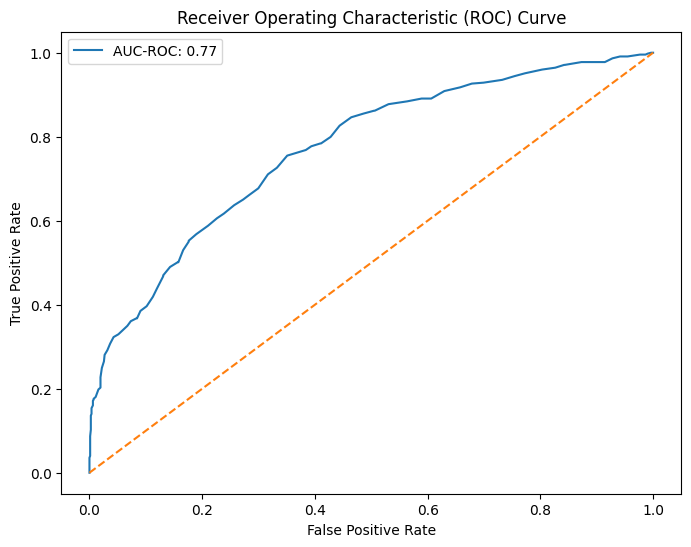

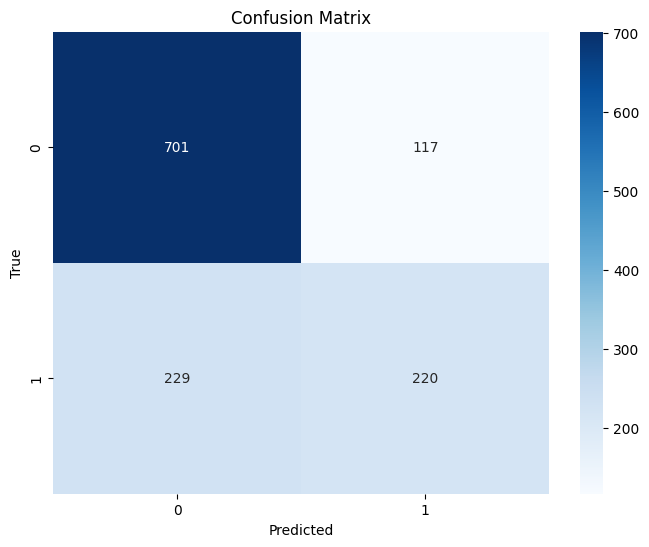

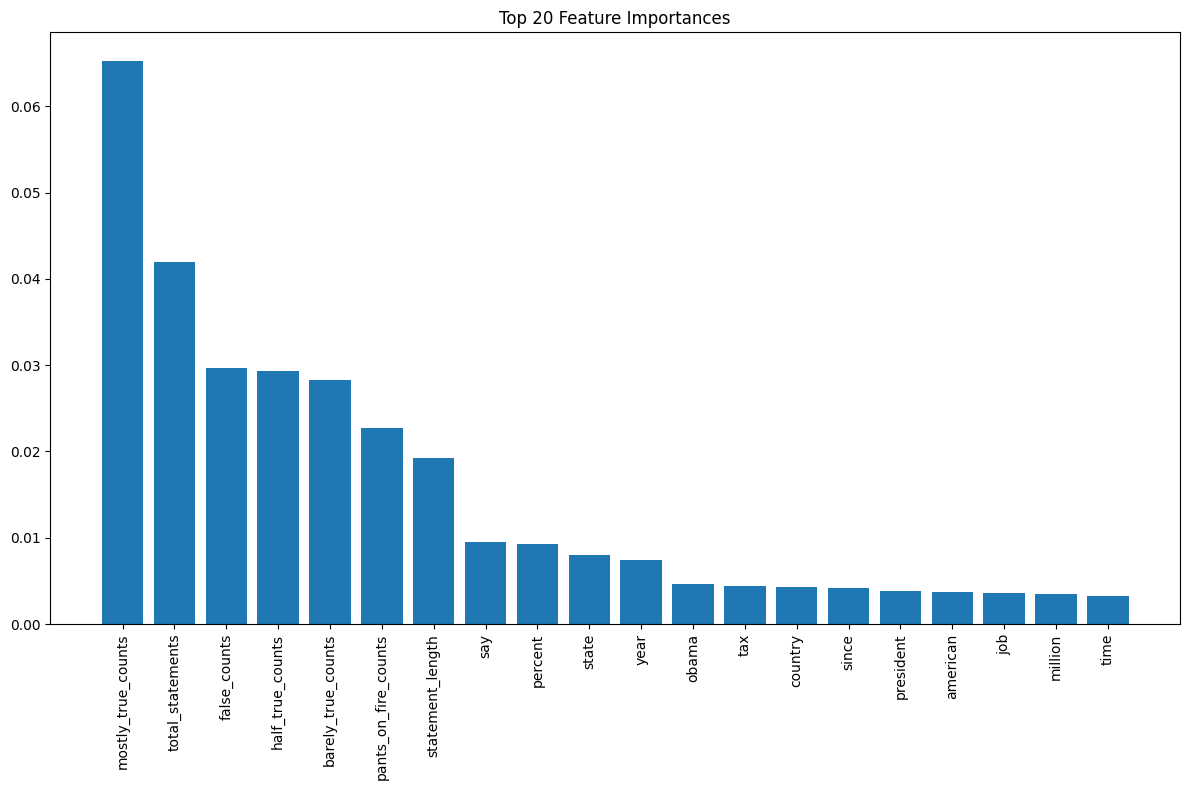

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, confusion_matrix

# ROC Curve
def plot_roc_curve(y_true, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC-ROC: {roc_auc_score(y_true, y_pred_proba):.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Feature Importance
def plot_feature_importance(model, feature_names, top_n=20):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:top_n]
    
    plt.figure(figsize=(12, 8))
    plt.title(f"Top {top_n} Feature Importances")
    plt.bar(range(top_n), importances[indices])
    plt.xticks(range(top_n), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()

# After model evaluation, add these lines:
print("\nGenerating performance visualizations...")

# Plot ROC curve
plot_roc_curve(y_test, y_test_pred)

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred)

# Plot feature importance
feature_names = tfidf.get_feature_names_out().tolist() + numerical_features
plot_feature_importance(rf_model, feature_names)

In [40]:
import joblib

def save_model(model, filename='random_forest_model.joblib'):
    joblib.dump(model, filename)
    print(f"Model saved as {filename}")

# Save the model
save_model(rf_model)

Model saved as random_forest_model.joblib


### Deep Learning Model: RoBERTa

In [26]:
# Prepare data for RoBERTa
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

def encode_for_roberta(texts, max_length=128):
    # Convert texts to a list if it's a pandas Series
    if isinstance(texts, pd.Series):
        texts = texts.tolist()
    return tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors='pt')

# Convert pandas Series to list before encoding
train_encodings = encode_for_roberta(train_df['statement'].tolist())
valid_encodings = encode_for_roberta(valid_df['statement'].tolist())
test_encodings = encode_for_roberta(test_df['statement'].tolist())

# Convert to PyTorch datasets
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = Dataset(train_encodings, train_df['label_encoded'].tolist())
valid_dataset = Dataset(valid_encodings, valid_df['label_encoded'].tolist())
test_dataset = Dataset(test_encodings, test_df['label_encoded'].tolist())

# Calculate class weights for RoBERTa
class_weights = compute_class_weight('balanced', classes=np.unique(train_df['label_encoded']), y=train_df['label_encoded'])
class_weights = torch.tensor(class_weights, dtype=torch.float)


Data preparation completed.
Random Forest training data shape: (13204, 5007)
RoBERTa training data size: 10240
Class weights for RoBERTa: tensor([0.7755, 1.4074])


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Assuming train_df is your training DataFrame and 'label_encoded' is the column with encoded labels
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_df['label_encoded']), y=train_df['label_encoded'])
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

print("Class weights:", class_weights)


In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
import os
from torch.nn import CrossEntropyLoss

# Set up GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def prepare_roberta_input(df, tokenizer, max_length=128):
    encoded_data = tokenizer.batch_encode_plus(
        df['statement'].tolist(),
        add_special_tokens=True,
        return_attention_mask=True,
        padding='max_length',
        max_length=max_length,
        truncation=True,
        return_tensors='pt'
    )
    input_ids = encoded_data['input_ids']
    attention_masks = encoded_data['attention_mask']
    labels = torch.tensor(df['label_encoded'].tolist())
    return input_ids, attention_masks, labels

# Prepare data
train_inputs, train_masks, train_labels = prepare_roberta_input(train_df, tokenizer)
valid_inputs, valid_masks, valid_labels = prepare_roberta_input(valid_df, tokenizer)
test_inputs, test_masks, test_labels = prepare_roberta_input(test_df, tokenizer)

# Create DataLoaders
batch_size = 32
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

valid_data = TensorDataset(valid_inputs, valid_masks, valid_labels)
valid_dataloader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [ ]:
# Set up RoBERTa model
model = RobertaForSequenceClassification.from_pretrained('roberta-large', num_labels=2)
model.to(device)

# Set up optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 4
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

In [ ]:
gradient_accumulation_steps = 4  # Adjust based on your memory constraints

In [ ]:
num_train_steps = len(train_dataloader) * epochs
num_warmup_steps = num_train_steps // 10  # 10% of total steps for warmup

optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=num_warmup_steps, 
                                            num_training_steps=num_train_steps)

In [ ]:
scaler = torch.cuda.amp.GradScaler()

In [ ]:
# Improvement: Implement early stopping
early_stopping_patience = 3
best_val_loss = float('inf')
no_improvement_count = 0

# Training loop
for epoch in range(epochs):
    print(f'\n======== Epoch {epoch+1} / {epochs} ========')
    print('Training...')
    
    model.train()
    total_loss = 0

    for step, batch in enumerate(tqdm(train_dataloader, desc="Training", unit="batch")):
        b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)
        
        # Use mixed precision training
        with torch.cuda.amp.autocast():
            outputs = model(b_input_ids, attention_mask=b_input_mask)
            logits = outputs.logits
            loss = loss_fn(logits, b_labels)
        
        # Normalize loss for gradient accumulation
        loss = loss / gradient_accumulation_steps
        
        # Backward pass with scaled gradients
        scaler.scale(loss).backward()
        
        if (step + 1) % gradient_accumulation_steps == 0:
            # Unscale gradients and clip them
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            # Optimizer step with scaled gradients
            scaler.step(optimizer)
            scaler.update()
            
            scheduler.step()
            optimizer.zero_grad()
        
        total_loss += loss.item() * gradient_accumulation_steps
        
    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Average training loss: {avg_train_loss:.4f}")
    
    # Validation
    model.eval()
    val_accuracy = []
    val_loss = []
    
    for batch in tqdm(valid_dataloader, desc="Validation", unit="batch"):
        b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)
        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_input_mask)
            logits = outputs.logits
            loss = loss_fn(logits, b_labels)
            val_loss.append(loss.item())
        
        predictions = torch.argmax(logits, dim=1)
        accuracy = (predictions == b_labels).float().mean()
        val_accuracy.append(accuracy.item())
    
    avg_val_loss = np.mean(val_loss)
    print(f"Validation Accuracy: {np.mean(val_accuracy):.4f}")
    print(f"Validation Loss: {avg_val_loss:.4f}")
    
    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        no_improvement_count = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_roberta_model.pt')
    else:
        no_improvement_count += 1
    
    if no_improvement_count >= early_stopping_patience:
        print("Early stopping triggered")
        break

model.load_state_dict(torch.load('best_roberta_model.pt'))

In [ ]:
# Improvement 6: Error analysis
def analyze_errors(model, dataloader, tokenizer):
    model.eval()
    errors = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Error Analysis", unit="batch"):
            b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)
            outputs = model(b_input_ids, attention_mask=b_input_mask)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)
            
            for input_id, true_label, pred_label in zip(b_input_ids, b_labels, predictions):
                if true_label != pred_label:
                    text = tokenizer.decode(input_id, skip_special_tokens=True)
                    errors.append((text, true_label.item(), pred_label.item()))
    return errors

error_cases = analyze_errors(model, test_dataloader, tokenizer)
print("\nSample Error Cases:")
for i, (text, true_label, pred_label) in enumerate(error_cases[:5]):
    print(f"Example {i+1}:")
    print(f"Text: {text}")
    print(f"True Label: {true_label}, Predicted Label: {pred_label}\n")

In [ ]:
# Improvement 7: Confusion Matrix Analysis
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix - RoBERTa (Binary Classification)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(np.arange(len(classes)) + 0.5, classes)
    plt.yticks(np.arange(len(classes)) + 0.5, classes)
    plt.show()

In [ ]:
plot_confusion_matrix(test_true_labels, test_predictions, ['False', 'True'])

print("\nModel training, evaluation, and analysis completed.")

In [ ]:
import torch
from transformers import RobertaTokenizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Assuming 'model' is your trained RoBERTa model and 'test_dataloader' is your DataLoader for the test set

def evaluate_model(model, test_dataloader, device):
    model.eval()
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for batch in test_dataloader:
            b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)
            
            outputs = model(b_input_ids, attention_mask=b_input_mask)
            logits = outputs.logits
            
            predictions = torch.argmax(logits, dim=1)
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(b_labels.cpu().numpy())
    
    return np.array(all_predictions), np.array(all_labels)

# 1. Print the performance metrics of this model
def print_performance_metrics(y_true, y_pred):
    print("\nModel Performance Metrics:")
    print("---------------------------")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred, average='weighted'):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred, average='weighted'):.4f}")
    print(f"F1-score: {f1_score(y_true, y_pred, average='weighted'):.4f}")
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['False', 'True']))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix - RoBERTa (Binary Classification)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks([0.5, 1.5], ['False', 'True'])
    plt.yticks([0.5, 1.5], ['False', 'True'])
    plt.show()

# Evaluate the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
predictions, true_labels = evaluate_model(model, test_dataloader, device)

# Print performance metrics
print_performance_metrics(true_labels, predictions)

In [ ]:
# 2. Save the model and tokenizer for later use
def save_model_and_tokenizer(model, tokenizer, save_dir='saved_roberta_model'):
    # Create directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # Save the model
    model.save_pretrained(save_dir)
    print(f"Model saved to {save_dir}")
    
    # Save the tokenizer
    tokenizer.save_pretrained(save_dir)
    print(f"Tokenizer saved to {save_dir}")

# Assuming 'tokenizer' is your RobertaTokenizer instance
save_model_and_tokenizer(model, tokenizer)

print("\nModel evaluation completed and model saved successfully.")

In [ ]:
# Evaluation on test set
model.eval()
test_predictions = []
test_true_labels = []
test_probabilities = []

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Testing", unit="batch"):
        b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)
        outputs = model(b_input_ids, attention_mask=b_input_mask)
        
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)
        predictions = torch.argmax(logits, dim=1)
        
        test_predictions.extend(predictions.cpu().numpy())
        test_true_labels.extend(b_labels.cpu().numpy())
        test_probabilities.extend(probabilities[:, 1].cpu().numpy())  # Probability of the positive class

# Convert to numpy arrays
test_predictions = np.array(test_predictions)
test_true_labels = np.array(test_true_labels)
test_probabilities = np.array(test_probabilities)

# Print classification report
print("\nRoBERTa Model Performance (Binary Classification):")
print(classification_report(test_true_labels, test_predictions, target_names=['False', 'True']))

# Confusion Matrix
cm = confusion_matrix(test_true_labels, test_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - RoBERTa (Binary Classification)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(test_true_labels, test_probabilities)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# Save the model
os.makedirs('saved_roberta_model_weighted', exist_ok=True)
model_save_path = 'saved_roberta_model_weighted/roberta_binary_classifier.pt'
torch.save(model.state_dict(), model_save_path)
tokenizer.save_pretrained('saved_roberta_model_weighted')
print(f"\nModel saved to {model_save_path}")

# Save the configuration
model.config.save_pretrained('saved_roberta_model_weighted')
print("Model configuration saved.")

In [ ]:
def get_important_words(model, tokenizer, input_ids, attention_mask, k=10):
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids.unsqueeze(0).to(device), 
                        attention_mask=attention_mask.unsqueeze(0).to(device),
                        output_attentions=True)  # Add this parameter
        
        # The attentions are now available in outputs.attentions
        attentions = outputs.attentions[-1].squeeze(0)  # Get the last layer's attention
    
    # Average attention across all heads
    avg_attention = attentions.mean(dim=0)
    
    # Get the attention for the [CLS] token
    cls_attention = avg_attention[0]
    
    # Get the top k words with highest attention
    top_k_indices = torch.topk(cls_attention, k).indices.cpu().numpy()
    
    important_words = [tokenizer.decode([input_ids[i]]).strip() for i in top_k_indices]
    return important_words

# Now, let's use this function:
sample_input = test_inputs[0]
sample_mask = test_masks[0]
important_words = get_important_words(model, tokenizer, sample_input, sample_mask)

print("\nMost important words for a sample input:")
print(", ".join(important_words))

# If you want to see the original input text:
original_text = tokenizer.decode(sample_input, skip_special_tokens=True)
print(f"\nOriginal text: {original_text}")


In [ ]:
# Get important words for a sample input
sample_input = test_inputs[0]
sample_mask = test_masks[0]
important_words = get_important_words(model, tokenizer, sample_input, sample_mask)

print("\nMost important words for a sample input:")
print(", ".join(important_words))

In [ ]:
# Function to make prediction on new text
def predict_statement(text, model, tokenizer):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)
    
    # Make prediction
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)
        prediction = torch.argmax(probabilities, dim=1).item()
    
    # Get label and probability
    label = "True" if prediction == 1 else "False"
    probability = probabilities[0][prediction].item()
    
    return label, probability

# Example usage of the prediction function
sample_statement = "The Earth is round."
predicted_label, predicted_probability = predict_statement(sample_statement, model, tokenizer)
print(f"\nSample statement: '{sample_statement}'")
print(f"Predicted: {predicted_label} (Probability: {predicted_probability:.2f})")

print("\nModel training, evaluation, and saving completed.")

In [ ]:
# Feature importance bar plot
from captum.attr import IntegratedGradients
import torch
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def get_feature_importance(model, tokenizer, input_text, target=1):
    model.eval()
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(device)
    input_embeddings = model.roberta.embeddings(input_ids)
    
    def forward_func(embeddings):
        return model(inputs_embeds=embeddings).logits[:, target]
    
    ig = IntegratedGradients(forward_func)
    attributions, delta = ig.attribute(input_embeddings, return_convergence_delta=True)
    
    attributions = attributions.sum(dim=2).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    attributions = attributions.cpu().detach().numpy()
    
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    
    return list(zip(tokens, attributions))

# Function to clean tokens
def clean_token(token):
    return token.replace('Ġ', '')

# Get feature importance for a sample input
sample_text = tokenizer.decode(test_inputs[0], skip_special_tokens=True)
feature_importance = get_feature_importance(model, tokenizer, sample_text)

# Sort by absolute importance and get top 20
top_20 = sorted(feature_importance, key=lambda x: abs(x[1]), reverse=True)[:20]

# Separate words and importance scores, cleaning the tokens
words, scores = zip(*[(clean_token(word), score) for word, score in top_20])

# Create the plot
plt.figure(figsize=(12, 8))
sns.barplot(x=list(scores), y=list(words), orient='h')
plt.title('Top 20 Most Important Features - RoBERTa Model')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

# Print the sample text
print(f"Sample text: {sample_text}")

# ANDREA CONTINUA DA QUI

# (Task 2) Topic Modelling

Usiamo LDA direi?